In [ ]:
# =========================================================
# Celda 1 de 2: Instalación de Dependencias
# (Esta celda reiniciará el entorno al finalizar)
# =========================================================
print("⏳ Instalando dependencias (prody, matplotlib)...")
!pip install prody matplotlib scipy -q
print("✅ Instalación completada. Reiniciando el entorno para cargar las nuevas librerías...")

# Este comando reinicia el kernel de Colab
import os
os.kill(os.getpid(), 9)

⏳ Instalando dependencias (prody, matplotlib)...


@> 1007 atoms and 1 coordinate set(s) were parsed in 0.08s.
DEBUG:.prody:1007 atoms and 1 coordinate set(s) were parsed in 0.08s.


✅ Librerías cargadas correctamente.

🔬 Analizando la estructura y las cargas

🗺️ Generando Mapa de Potencial Electrostático por Capas...
✅ ¡Imagen 'af_pose_electrostatics_final.png' generada y guardada!


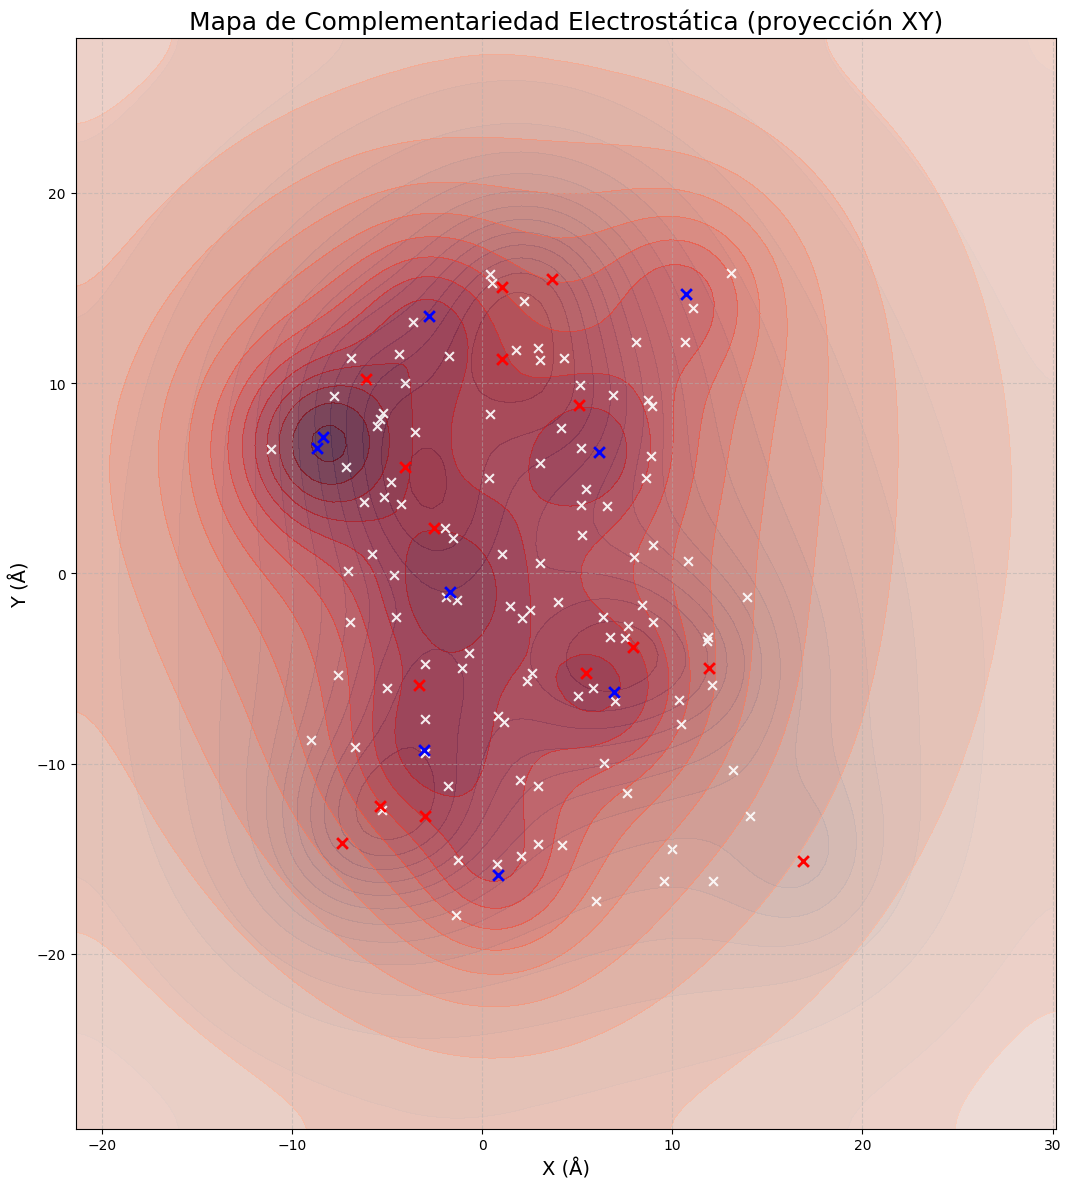

In [6]:
# ====================================================================================
# Celda Final: Visualización por Capas (Versión Corregida)
# ====================================================================================

import prody
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import os

print("✅ Librerías cargadas correctamente.")

# --- Carga y Análisis de la Estructura ---
print("\n" + "="*50)
print("🔬 Analizando la estructura y las cargas")
print("="*50)

pdb_file = "PIA_KRASv2Nb_renumbered.pdb"
if not os.path.exists(pdb_file):
    print(f"🚨 Error: El archivo '{pdb_file}' no se encuentra. Súbelo de nuevo.")
else:
    complex = prody.parsePDB(pdb_file, biomol=True, secondary=True)
    positive_res = ["ARG", "LYS", "HIS"]
    negative_res = ["ASP", "GLU"]

    # --- Generación del Mapa de Potencial ---
    print("\n" + "="*50)
    print("🗺️ Generando Mapa de Potencial Electrostático por Capas...")
    print("="*50)

    pos_atoms_selection = complex.select(f"resname {' '.join(positive_res)} and name CA")
    neg_atoms_selection = complex.select(f"resname {' '.join(negative_res)} and name CA")
    neutral_atoms_selection = complex.select(f"not (resname {' '.join(positive_res)} or resname {' '.join(negative_res)}) and name CA")

    pos_atoms = pos_atoms_selection.getCoords() if pos_atoms_selection is not None else None
    neg_atoms = neg_atoms_selection.getCoords() if neg_atoms_selection is not None else None
    neutral_atoms = neutral_atoms_selection.getCoords() if neutral_atoms_selection is not None else None

    min_coords = complex.getCoords().min(axis=0)
    max_coords = complex.getCoords().max(axis=0)
    padding = 10
    x_grid = np.linspace(min_coords[0] - padding, max_coords[0] + padding, 100)
    y_grid = np.linspace(min_coords[1] - padding, max_coords[1] + padding, 100)
    X, Y = np.meshgrid(x_grid, y_grid)

    # --- CALCULAR POTENCIALES POSITIVO Y NEGATIVO POR SEPARADO ---
    Z_pos = np.zeros_like(X)
    if pos_atoms is not None:
        for x, y, z in pos_atoms:
            Z_pos += 1 / np.sqrt((X - x)**2 + (Y - y)**2 + 1)

    Z_neg = np.zeros_like(X)
    if neg_atoms is not None:
        for x, y, z in neg_atoms:
            Z_neg += 1 / np.sqrt((X - x)**2 + (Y - y)**2 + 1)

    # Suavizar cada capa
    Z_pos_smooth = gaussian_filter(Z_pos, sigma=4)
    Z_neg_smooth = gaussian_filter(Z_neg, sigma=4)

    # --- Generar la gráfica por capas ---
    fig, ax = plt.subplots(figsize=(12, 12))

    # --- DIBUJAR LAS DOS CAPAS CON TRANSPARENCIA ---
    # Normalizar cada capa de 0 a 1 para un coloreado consistente
    if Z_neg_smooth.max() > 0:
      ax.contourf(X, Y, Z_neg_smooth, levels=15, cmap='Blues', alpha=0.6, vmin=0, vmax=Z_neg_smooth.max())
    if Z_pos_smooth.max() > 0:
      ax.contourf(X, Y, Z_pos_smooth, levels=15, cmap='Reds', alpha=0.6, vmin=0, vmax=Z_pos_smooth.max())

    # Superponer los átomos (CA de cada residuo)
    if neutral_atoms is not None: ax.scatter(neutral_atoms[:, 0], neutral_atoms[:, 1], c='white', marker='x', s=40, alpha=0.9, linewidths=1.5)
    if pos_atoms is not None: ax.scatter(pos_atoms[:, 0], pos_atoms[:, 1], c='blue', marker='x', s=60, alpha=1, linewidths=2)
    if neg_atoms is not None: ax.scatter(neg_atoms[:, 0], neg_atoms[:, 1], c='red', marker='x', s=60, alpha=1, linewidths=2)

    ax.set_xlabel("X (Å)", fontsize=14)
    ax.set_ylabel("Y (Å)", fontsize=14)
    ax.set_title("Mapa de Complementariedad Electrostática (proyección XY)", fontsize=18)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_aspect('equal', adjustable='box')
    ax.set_facecolor('#e9e9e9') # Fondo gris claro para mejor contraste

    plt.tight_layout()
    plt.savefig("af_pose_electrostatics_final.png", dpi=150, bbox_inches='tight')
    print("✅ ¡Imagen 'af_pose_electrostatics_final.png' generada y guardada!")

    plt.show()